<a href="https://colab.research.google.com/github/FernandoJRS/violence-detection-deeplearning/blob/main/ViolenceActionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Kaggle and Load Datasets

In [1]:

!pip install -q kaggle

# Download Hockey Fights
# !wget https://www.kaggle.com/frendon/hockeyfight/download

# Download Movies Fights
# !wget https://www.kaggle.com/frendon/moviefights/download

# Download Violent Flows
# !wget https://www.kaggle.com/frendon/violentflows/download


from google.colab import files

# This will prompt you to upload the kaggle.json
files.upload()  


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
# Than copy the kaggle API
!kaggle datasets download -d frendon/hockeyfight
!kaggle datasets download -d frendon/moviefights
!kaggle datasets download -d frendon/violentflows

# Make directory and unzip

# Create a directory
!mkdir hockey_fights  
!mkdir movies_fights
!mkdir violent_flows

# Unzip data
!unzip -q hockeyfight.zip -d hockey_fights/  
!unzip -q moviefights.zip -d movies_fights/
!unzip -q violentflows.zip -d violent_flows/

'\n!pip install -q kaggle\n\n# Download Hockey Fights\n# !wget https://www.kaggle.com/frendon/hockeyfight/download\n\n# Download Movies Fights\n# !wget https://www.kaggle.com/frendon/moviefights/download\n\n# Download Violent Flows\n# !wget https://www.kaggle.com/frendon/violentflows/download\n\n\nfrom google.colab import files\n\n# This will prompt you to upload the kaggle.json\nfiles.upload()  \n\n\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json  # set permission\n# Than copy the kaggle API\n!kaggle datasets download -d frendon/hockeyfight\n!kaggle datasets download -d frendon/moviefights\n!kaggle datasets download -d frendon/violentflows\n\n# Make directory and unzip\n\n# Create a directory\n!mkdir hockey_fights  \n!mkdir movies_fights\n!mkdir violent_flows\n\n# Unzip data\n!unzip -q hockeyfight.zip -d hockey_fights/  \n!unzip -q moviefights.zip -d movies_fights/\n!unzip -q violentflows.zip -d violent_flows/\n'

## Import Modules

In [2]:
import random
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sklearn

from sklearn.model_selection import StratifiedKFold
from keras import Model
from keras.utils import np_utils

## Utils Functions for Pre-processing Data 

In [3]:
import cv2
import numpy as np


def extract_videos3D(video_input_file_path, height, width):
    '''
    The extract_videos3D function reads a video and returns a list of frames as output.
    '''
    video_frames = list()
    cap = cv2.VideoCapture(video_input_file_path)
    while cap.isOpened():

        ret, frame = cap.read()

        if ret:
            frame = cv2.resize(frame, (width, height))
            video_frames.append(frame)

        else:
            break

    cap.release()
    cv2.destroyAllWindows()

    return video_frames


def extract_videos3D_optical_flow(video_input_file_path, height, width):
    '''
    The extract_videos3D function reads a video and returns as output a list of frames processed as optical flow.
    '''
    video_frames_optical_flow = list()
    i = 0
    cap = cv2.VideoCapture(video_input_file_path)
    ret1, frame1 = cap.read()
    frame1 = cv2.resize(frame1, (width, height))
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255

    if not cap.isOpened():
        print("Error opening video stream or file")

    while cap.isOpened():

        ret2, frame2 = cap.read()

        if ret2:

            frame2 = cv2.resize(frame2, (width, height))
            next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            video_frames_optical_flow.append(bgr)
        else:
            break

        i += 1
        prvs = next

    cap.release()
    cv2.destroyAllWindows()
    return video_frames_optical_flow


def extract_videos3D_frames_substraction(video_input_file_path, height, width):
    '''
    The extract_videos3D function reads a video and returns as output a list of frames processed as the subtraction between two consecutive frames.
    '''
    video_frames = list()
    cap = cv2.VideoCapture(video_input_file_path)
    ret1, frame1 = cap.read()
    frame1 = cv2.resize(frame1, (width, height))

    while cap.isOpened():

        ret2, frame2 = cap.read()
        if ret2:
            frame2 = cv2.resize(frame2, (width, height))
            frame = frame1 - frame2
            video_frames.append(frame)
        else:
            break

        frame1 = frame2

    cap.release()
    cv2.destroyAllWindows()
    return video_frames

## Classifier Model Definition

In [4]:
class ClassifierHAR3D(object):

    def __init__(self):

        self.width = None
        self.height = None
        self.channels = None
        self.time = None
        self.batch_size_train = None
        self.batch_size_validation = None
        self.batch_size_test = None
        self.labels = None
        self.pathTrain = None
        self.pathTest = None
        self.pathValidation = None
        self.ftr = None
        self.ftv = None
        self.fts = None
        self.ftr_labels = None
        self.ftv_labels = None
        self.fts_labels = None
        self.predictions = None

    def generatorTrain3D(self):

        while True:

            for count in range(int(len(self.ftr) / self.batch_size_train)):

                batch_start = self.batch_size_train * count
                batch_stop = self.batch_size_train + (self.batch_size_train * count)

                lx1 = list()
                ly = list()

                for i in range(batch_start, batch_stop):

                    if self.ftr[i] != '.ipynb_checkpoints':

                        ly.append(self.ftr_labels[i])

                        optical_flow = extract_videos3D(self.pathTrain + self.ftr[i], self.height,
                                                                     self.width)

                        if len(optical_flow) < self.time:
                            while len(optical_flow) < self.time:
                                optical_flow.append(optical_flow[-1])
                        else:
                            optical_flow = optical_flow[0:self.time]

                        lx1.append(optical_flow)

                x1 = np.array(lx1)
                x1 = x1.astype('float32')
                x1 /= 255
                x1 = x1.reshape((x1.shape[0], self.time, self.height, self.width, self.channels))

                y = np.array(ly)
                y = np_utils.to_categorical(y, len(self.labels))

                yield x1, y

    def generatorTest3D(self):

        while True:

            for count in range(int(len(self.fts) / self.batch_size_test)):

                batch_start = self.batch_size_test * count
                batch_stop = self.batch_size_test + (self.batch_size_test * count)

                lx1 = list()
                ly = list()

                for i in range(batch_start, batch_stop):

                    if self.fts[i] != '.ipynb_checkpoints':

                        ly.append(self.fts_labels[i])

                        optical_flow = extract_videos3D(self.pathTest + self.fts[i], self.height, self.width)

                        if len(optical_flow) < self.time:
                            while len(optical_flow) < self.time:
                                optical_flow.append(optical_flow[-1])
                        else:
                            optical_flow = optical_flow[0:self.time]

                        lx1.append(optical_flow)

                x1 = np.array(lx1)
                x1 = x1.astype('float32')
                x1 /= 255
                x1 = x1.reshape((x1.shape[0], self.time, self.height, self.width, self.channels))

                y = np.array(ly)
                y = np_utils.to_categorical(y, len(self.labels))

                yield x1, y

    # Models

    def model_dense(self, input_shape):

        net_input = tf.keras.layers.Input(input_shape, name='feature')

        net = tf.keras.layers.Conv3D(filters=32, kernel_size=(7, 7, 7), strides=(1, 2, 2), activation='relu', padding='same')(net_input)
        net = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(net)

        net1 = tf.keras.layers.BatchNormalization()(net)
        net1 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net1)
        net1 = tf.keras.layers.BatchNormalization()(net1)
        net1 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net1)

        net2 = tf.keras.layers.BatchNormalization()(net1)
        net2 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net2)
        net2 = tf.keras.layers.BatchNormalization()(net2)
        net2 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net2)

        c1 = tf.keras.layers.Concatenate()([net1, net2])

        net3 = tf.keras.layers.BatchNormalization()(c1)
        net3 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net3)
        net3 = tf.keras.layers.BatchNormalization()(net3)
        net3 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net3)

        c2 = tf.keras.layers.Concatenate()([net1, net2, net3])

        net4 = tf.keras.layers.BatchNormalization()(c2)
        net4 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net4)
        net4 = tf.keras.layers.BatchNormalization()(net4)
        net4 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net4)

        c3 = tf.keras.layers.Concatenate()([net1, net2, net3, net4])

        net5 = tf.keras.layers.BatchNormalization()(c3)
        net5 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net5)
        net5 = tf.keras.layers.BatchNormalization()(net5)
        net5 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net5)

        c4 = tf.keras.layers.Concatenate()([net1, net2, net3, net4, net5])

        net6 = tf.keras.layers.BatchNormalization()(c4)
        net6 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net6)
        net6 = tf.keras.layers.BatchNormalization()(net6)
        net6 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net6)

        t1 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net6)
        t1 = tf.keras.layers.AveragePooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(t1)

        net7 = tf.keras.layers.BatchNormalization()(t1)
        net7 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net7)
        net7 = tf.keras.layers.BatchNormalization()(net7)
        net7 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net7)

        net8 = tf.keras.layers.BatchNormalization()(net7)
        net8 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net8)
        net8 = tf.keras.layers.BatchNormalization()(net8)
        net8 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net8)

        c5 = tf.keras.layers.Concatenate()([net7, net8])

        net9 = tf.keras.layers.BatchNormalization()(c5)
        net9 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net9)
        net9 = tf.keras.layers.BatchNormalization()(net9)
        net9 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net9)

        c6 = tf.keras.layers.Concatenate()([net7, net8, net9])

        net10 = tf.keras.layers.BatchNormalization()(c6)
        net10 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net10)
        net10 = tf.keras.layers.BatchNormalization()(net10)
        net10 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net10)

        c7 = tf.keras.layers.Concatenate()([net7, net8, net9, net10])

        net11 = tf.keras.layers.BatchNormalization()(c7)
        net11 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net11)
        net11 = tf.keras.layers.BatchNormalization()(net11)
        net11 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net11)

        c8 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11])

        net12 = tf.keras.layers.BatchNormalization()(c8)
        net12 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net12)
        net12 = tf.keras.layers.BatchNormalization()(net12)
        net12 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net12)

        c9 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12])

        net13 = tf.keras.layers.BatchNormalization()(c9)
        net13 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net13)
        net13 = tf.keras.layers.BatchNormalization()(net13)
        net13 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net13)

        c10 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12, net13])

        net14 = tf.keras.layers.BatchNormalization()(c10)
        net14 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net14)
        net14 = tf.keras.layers.BatchNormalization()(net14)
        net14 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net14)

        c11 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12, net13, net14])

        net15 = tf.keras.layers.BatchNormalization()(c11)
        net15 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net15)
        net15 = tf.keras.layers.BatchNormalization()(net15)
        net15 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net15)

        c12 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12, net13, net14, net15])

        net16 = tf.keras.layers.BatchNormalization()(c12)
        net16 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net16)
        net16 = tf.keras.layers.BatchNormalization()(net16)
        net16 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net16)

        c13 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12, net13, net14, net15, net16])

        net17 = tf.keras.layers.BatchNormalization()(c13)
        net17 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net17)
        net17 = tf.keras.layers.BatchNormalization()(net17)
        net17 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net17)

        c14 = tf.keras.layers.Concatenate()([net7, net8, net9, net10, net11, net12, net13, net14, net15, net16, net17])

        net18 = tf.keras.layers.BatchNormalization()(c14)
        net18 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net18)
        net18 = tf.keras.layers.BatchNormalization()(net18)
        net18 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net18)

        t2 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net18)
        t2 = tf.keras.layers.AveragePooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(t2)

        net19 = tf.keras.layers.BatchNormalization()(t2)
        net19 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net19)
        net19 = tf.keras.layers.BatchNormalization()(net19)
        net19 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net19)

        net20 = tf.keras.layers.BatchNormalization()(net19)
        net20 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net20)
        net20 = tf.keras.layers.BatchNormalization()(net20)
        net20 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net20)

        c15 = tf.keras.layers.Concatenate()([net19, net20])

        net21 = tf.keras.layers.BatchNormalization()(c15)
        net21 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net21)
        net21 = tf.keras.layers.BatchNormalization()(net21)
        net21 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net21)

        c16 = tf.keras.layers.Concatenate()([net19, net20, net21])

        net22 = tf.keras.layers.BatchNormalization()(c16)
        net22 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net22)
        net22 = tf.keras.layers.BatchNormalization()(net22)
        net22 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net22)

        c17 = tf.keras.layers.Concatenate()([net19, net20, net21, net22])

        net23 = tf.keras.layers.BatchNormalization()(c17)
        net23 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net23)
        net23 = tf.keras.layers.BatchNormalization()(net23)
        net23 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net23)

        c18 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23])

        net24 = tf.keras.layers.BatchNormalization()(c18)
        net24 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net24)
        net24 = tf.keras.layers.BatchNormalization()(net24)
        net24 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net24)

        c19 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23, net24])

        net25 = tf.keras.layers.BatchNormalization()(c19)
        net25 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net25)
        net25 = tf.keras.layers.BatchNormalization()(net25)
        net25 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net25)

        c20 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23, net24, net25])

        net26 = tf.keras.layers.BatchNormalization()(c20)
        net26 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net26)
        net26 = tf.keras.layers.BatchNormalization()(net26)
        net26 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net26)

        c21 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23, net24, net25, net26])

        net27 = tf.keras.layers.BatchNormalization()(c21)
        net27 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net27)
        net27 = tf.keras.layers.BatchNormalization()(net27)
        net27 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net27)

        c22 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23, net24, net25, net26, net27])

        net28 = tf.keras.layers.BatchNormalization()(c22)
        net28 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net28)
        net28 = tf.keras.layers.BatchNormalization()(net28)
        net28 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net28)

        c23 = tf.keras.layers.Concatenate()([net19, net20, net21, net22, net23, net24, net25, net26, net27, net28])

        net29 = tf.keras.layers.BatchNormalization()(c23)
        net29 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net29)
        net29 = tf.keras.layers.BatchNormalization()(net29)
        net29 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net29)

        c24 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29])

        net30 = tf.keras.layers.BatchNormalization()(c24)
        net30 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net30)
        net30 = tf.keras.layers.BatchNormalization()(net30)
        net30 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net30)

        c25 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30])

        net31 = tf.keras.layers.BatchNormalization()(c25)
        net31 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net31)
        net31 = tf.keras.layers.BatchNormalization()(net31)
        net31 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net31)

        c26 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31])

        net32 = tf.keras.layers.BatchNormalization()(c26)
        net32 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net32)
        net32 = tf.keras.layers.BatchNormalization()(net32)
        net32 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net32)

        c27 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32])

        net33 = tf.keras.layers.BatchNormalization()(c27)
        net33 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net33)
        net33 = tf.keras.layers.BatchNormalization()(net33)
        net33 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net33)

        c28 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33])

        net34 = tf.keras.layers.BatchNormalization()(c28)
        net34 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net34)
        net34 = tf.keras.layers.BatchNormalization()(net34)
        net34 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net34)

        c29 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34])

        net35 = tf.keras.layers.BatchNormalization()(c29)
        net35 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net35)
        net35 = tf.keras.layers.BatchNormalization()(net35)
        net35 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net35)

        c30 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35])

        net36 = tf.keras.layers.BatchNormalization()(c30)
        net36 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net36)
        net36 = tf.keras.layers.BatchNormalization()(net36)
        net36 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net36)

        c31 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36])

        net37 = tf.keras.layers.BatchNormalization()(c31)
        net37 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net37)
        net37 = tf.keras.layers.BatchNormalization()(net37)
        net37 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net37)

        c32 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36, net37])

        net38 = tf.keras.layers.BatchNormalization()(c32)
        net38 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net38)
        net38 = tf.keras.layers.BatchNormalization()(net38)
        net38 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net38)

        c33 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36, net37, net38])

        net39 = tf.keras.layers.BatchNormalization()(c33)
        net39 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net39)
        net39 = tf.keras.layers.BatchNormalization()(net39)
        net39 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net39)

        c34 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36, net37, net38, net39])

        net40 = tf.keras.layers.BatchNormalization()(c34)
        net40 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net40)
        net40 = tf.keras.layers.BatchNormalization()(net40)
        net40 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net40)

        c35 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36, net37, net38, net39, net40])

        net41 = tf.keras.layers.BatchNormalization()(c35)
        net41 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net41)
        net41 = tf.keras.layers.BatchNormalization()(net41)
        net41 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net41)

        c36 = tf.keras.layers.Concatenate()(
            [net19, net20, net21, net22, net23, net24, net25, net26, net27, net28, net29, net30, net31, net32, net33,
             net34, net35, net36, net37, net38, net39, net40, net41])

        net42 = tf.keras.layers.BatchNormalization()(c36)
        net42 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net42)
        net42 = tf.keras.layers.BatchNormalization()(net42)
        net42 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net42)

        t3 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net42)
        t3 = tf.keras.layers.AveragePooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2))(t3)

        net43 = tf.keras.layers.BatchNormalization()(t3)
        net43 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net43)
        net43 = tf.keras.layers.BatchNormalization()(net43)
        net43 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net43)

        net44 = tf.keras.layers.BatchNormalization()(net43)
        net44 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net44)
        net44 = tf.keras.layers.BatchNormalization()(net44)
        net44 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net44)

        c37 = tf.keras.layers.Concatenate()([net43, net44])

        net45 = tf.keras.layers.BatchNormalization()(c37)
        net45 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net45)
        net45 = tf.keras.layers.BatchNormalization()(net45)
        net45 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net45)

        c38 = tf.keras.layers.Concatenate()([net43, net44, net45])

        net46 = tf.keras.layers.BatchNormalization()(c38)
        net46 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net46)
        net46 = tf.keras.layers.BatchNormalization()(net46)
        net46 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net46)

        c39 = tf.keras.layers.Concatenate()([net43, net44, net45, net46])

        net47 = tf.keras.layers.BatchNormalization()(c39)
        net47 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net47)
        net47 = tf.keras.layers.BatchNormalization()(net47)
        net47 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net47)

        c40 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47])

        net48 = tf.keras.layers.BatchNormalization()(c40)
        net48 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net48)
        net48 = tf.keras.layers.BatchNormalization()(net48)
        net48 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net48)

        c41 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47, net48])

        net49 = tf.keras.layers.BatchNormalization()(c41)
        net49 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net49)
        net49 = tf.keras.layers.BatchNormalization()(net49)
        net49 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net49)

        c42 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47, net48, net49])

        net50 = tf.keras.layers.BatchNormalization()(c42)
        net50 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net50)
        net50 = tf.keras.layers.BatchNormalization()(net50)
        net50 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net50)

        c43 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47, net48, net49, net50])

        net51 = tf.keras.layers.BatchNormalization()(c43)
        net51 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net51)
        net51 = tf.keras.layers.BatchNormalization()(net51)
        net51 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net51)

        c44 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47, net48, net49, net50, net51])

        net52 = tf.keras.layers.BatchNormalization()(c44)
        net52 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net52)
        net52 = tf.keras.layers.BatchNormalization()(net52)
        net52 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net52)

        c45 = tf.keras.layers.Concatenate()([net43, net44, net45, net46, net47, net48, net49, net50, net51, net52])

        net53 = tf.keras.layers.BatchNormalization()(c45)
        net53 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net53)
        net53 = tf.keras.layers.BatchNormalization()(net53)
        net53 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net53)

        c46 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53])

        net54 = tf.keras.layers.BatchNormalization()(c46)
        net54 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net54)
        net54 = tf.keras.layers.BatchNormalization()(net54)
        net54 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net54)

        c47 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53, net54])

        net55 = tf.keras.layers.BatchNormalization()(c47)
        net55 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net55)
        net55 = tf.keras.layers.BatchNormalization()(net55)
        net55 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net55)

        c48 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53, net54, net55])

        net56 = tf.keras.layers.BatchNormalization()(c48)
        net56 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net56)
        net56 = tf.keras.layers.BatchNormalization()(net56)
        net56 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net56)

        c49 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53, net54, net55, net56])

        net57 = tf.keras.layers.BatchNormalization()(c49)
        net57 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net57)
        net57 = tf.keras.layers.BatchNormalization()(net57)
        net57 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net57)

        c50 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53, net54, net55, net56, net57])

        net58 = tf.keras.layers.BatchNormalization()(c50)
        net58 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net58)
        net58 = tf.keras.layers.BatchNormalization()(net58)
        net58 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net58)

        c51 = tf.keras.layers.Concatenate()(
            [net43, net44, net45, net46, net47, net48, net49, net50, net51, net52, net53, net54, net55, net56, net57,
             net58])

        net59 = tf.keras.layers.BatchNormalization()(c51)
        net59 = tf.keras.layers.Conv3D(filters=32, kernel_size=(1, 1, 1), activation='relu', padding='same')(net59)
        net59 = tf.keras.layers.BatchNormalization()(net59)
        net59 = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(net59)

        net59 = tf.keras.layers.AveragePooling3D(pool_size=(1, 3, 3))(net59)

        net59 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=int(32/4), attention_axes=(1, 2, 3))(net59, net59, net59, None)

        net59 = tf.keras.layers.Bidirectional(
            tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=True))(net59)

        net59 = tf.keras.layers.Flatten()(net59)

        net59 = tf.keras.layers.Dense(128)(net59)
        net59 = tf.keras.layers.Dropout(0.25)(net59)
        net59 = tf.keras.layers.Dense(16)(net59)
        net59 = tf.keras.layers.Dropout(0.25)(net59)
        output = tf.keras.layers.Dense(len(self.labels), activation='softmax')(net59)

        model = Model(inputs=net_input, outputs=output)

        return model

## Training and Evaluate Model

In [5]:
iteration = 1

datasets_path = ['movies_fights/', 'hockey_fights/', 'violent_flows/']
data_set = datasets_path[0] + 'Data/'

X, y = list(), list()

for file in os.listdir(data_set):
    if 'NV' in file:
        y.append(0)
        X.append(file)
    else:
        y.append(1)
        X.append(file)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = None, None, None, None

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

trainXY = list(zip(X_train, y_train))
testXY = list(zip(X_test, y_test))

random.shuffle(trainXY)
random.shuffle(testXY)

X_train, y_train = zip(*trainXY)
X_test, y_test = zip(*testXY)

classifier = ClassifierHAR3D()
classifier.channels = 3
classifier.width = 100
classifier.height = 100
classifier.time = 50
classifier.batch_size_train = 8
classifier.batch_size_test = 1
classifier.labels = [0, 1]
classifier.pathTrain = data_set
classifier.pathTest = data_set
classifier.ftr = X_train
classifier.fts = X_test
classifier.ftr_labels = y_train
classifier.fts_labels = y_test

model = classifier.model_dense((classifier.time, classifier.height, classifier.width, classifier.channels))


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(classifier.generatorTrain3D(),
                    epochs=100,
                    shuffle=True,
                    verbose=1,
                    steps_per_epoch=int(len(classifier.ftr) / classifier.batch_size_train))

Epoch 1/100
200/200 [==============================] - 189s 828ms/step - loss: 0.3495 - categorical_accuracy: 0.8662

dict_keys(['loss', 'categorical_accuracy'])


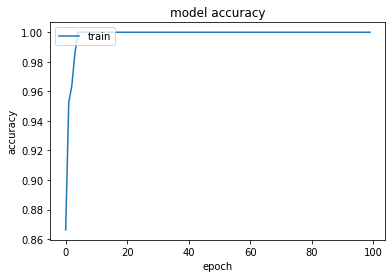

In [6]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

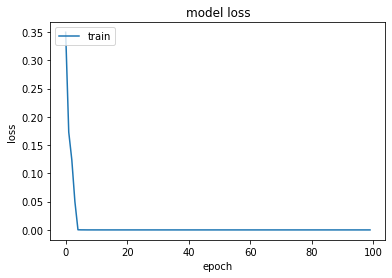

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [8]:
start = time.time()
classifier.predictions = model.predict(classifier.generatorTest3D(),
                                       steps=len(classifier.fts) / classifier.batch_size_test,
                                       max_queue_size=10,
                                       verbose=2)
end = time.time()
print('Inference time: ' + str((end - start)/len(classifier.fts)))

classifier.predictions = np.argmax(classifier.predictions, axis=1)
test_accuracy = sklearn.metrics.accuracy_score(classifier.fts_labels, classifier.predictions, normalize=True)

400/400 - 44s - 44s/epoch - 110ms/step
Inference time: 0.11134365558624268


In [9]:
model.save(datasets_path[0] + '/Results/model.h5')

In [10]:
print('Accurcay Score: ' + str(test_accuracy))

Accurcay Score: 1.0


In [11]:
iteration += 1